In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import cv2
import os
import pickle

# Import Data
and visualize a few examples

In [2]:
p1 = np.load('keren/Point39.npz', allow_pickle=True)
X1 = p1['X']
Y1 = p1['y']
C1 = p1['cell_types']
C1 = C1.item()

In [3]:
if (os.path.isfile('full_preprocessed_data.csv') == False):
    !curl -o keren.tar.gz https://storage.googleapis.com/bebi205-spring2023/keren.tar.gz
    !tar -xzvf keren.tar.gz

In [4]:
y0 = Y1[0,:,:,0]
y1 = Y1[0,:,:,1]

Checking out the y mask

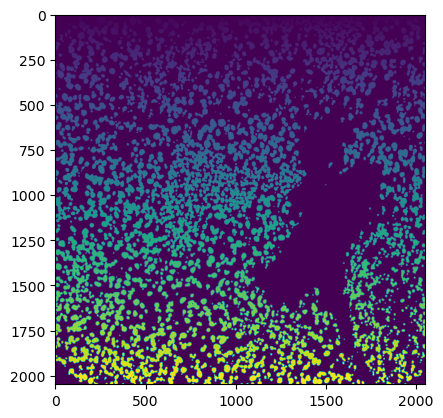

In [5]:
plt.imshow(Y1[0][:,:,1])

Mapping the instance segmentation to semantic segmentation via cell types

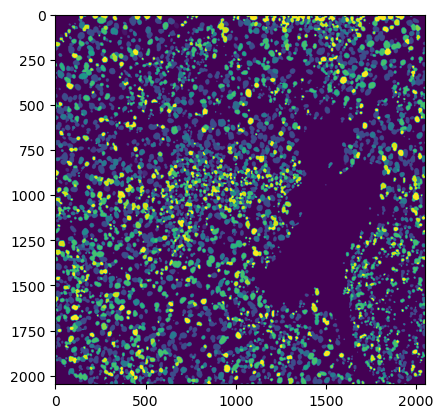

In [6]:
f = lambda x: C1.get(x)
f_vec = np.vectorize(f)
y_ = f_vec(y1)
plt.imshow(y_)

In [7]:
X_n = skimage.exposure.equalize_hist(X1[0])


In [8]:
X_n.shape

(2048, 2048, 51)

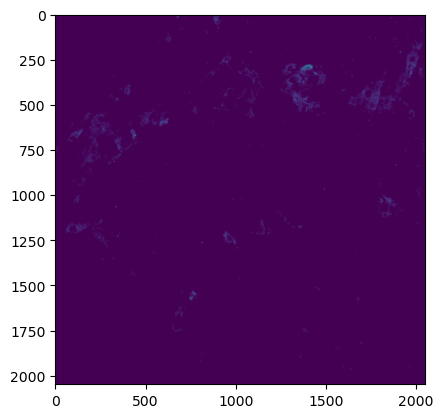

In [9]:
plt.imshow(X1[0,:,:,30])

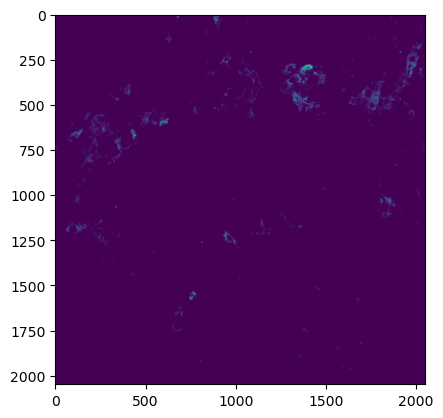

In [10]:
plt.imshow(X_n[:,:,30])

# Making training data




In [11]:
def normalize(X):
  X_n = []
  #for c in range(51):
    #X_n.append(skimage.exposure.equalize_hist(X[:,:,c]))
  #return np.array(X_n)
  return skimage.exposure.equalize_hist(X)

def normalize_(X):
    X_n = np.zeros(np.shape(X))
    clahe = cv2.createCLAHE()
    for c in range(51):
        img = X[:,:,c].astype(np.uint8)
        X_n[:,:,c] = clahe.apply(img)
    return X_n

def load_img(file):
  p = np.load(file, allow_pickle=True)
  if(len(p['X'])) > 1:
    print('multiple images in file:',id)
  X = p['X'][0]
  Y = p['y'][0]
  C = p['cell_types']
  C = C.item()

  X = normalize_(X)
  
  return X,Y,C

def get_cell_box(cell_coord):
  y = cell_coord.transpose()[0]
  x = cell_coord.transpose()[1]

  y_min = np.min(y)
  y_max = np.max(y)

  x_min = np.min(x)
  x_max = np.max(x)

  return y_min,y_max,x_min,x_max

def avg_whole_cell_size(Y_cyto):
  """ chooses 100 random whole cell segmentations, 
      prints std deviation and returns avg dimension"""
  sample = np.random.choice(np.unique(Y_cyto),size = 100)
  x_len = []
  y_len = []
  n = 0
  for cell in sample:
    if cell == 0:
      continue
    cell_coord = np.argwhere(Y_cyto == cell)
    y_min,y_max,x_min,x_max = get_cell_box(cell_coord)
    x_len.append( x_max-x_min)
    y_len.append( y_max-y_min)
    n+=1
  print('. x avg:',np.mean(x_len),'x std:',np.std(x_len))
  print('. y avg:',np.mean(y_len),'y std:',np.std(y_len))
  avg_size = int((np.mean(x_len)+np.mean(y_len))/2)
  print('. Choosing bounding box size =',avg_size)
  return avg_size

def get_coord(Y):
  """ input: Y
      returns: bounding boxes for nuclei as well as average bounding box size
      for whole cells"""
  Y_nuc = Y[:,:,0]
  Y_cyto = Y[:,:,1]

  size = avg_whole_cell_size(Y_cyto)
  
  values = np.unique(Y_nuc)
  coords = {}
  for cell in values:
    if cell == 0:
      continue
    cell_coord = np.argwhere(Y_nuc == cell)
    y_min,y_max,x_min,x_max = get_cell_box(cell_coord)
    coords[cell] = [y_min,y_max,x_min,x_max]

  return coords,size

def crop_cell(X,cell,coords,size = 0):
  """crops cell via bounding box generated by nucleus centroid and size. 
    size argument currently is the average whole cell size"""

  coords_ = coords.copy()
  if size != 0:
    center_y =(coords_[0]+coords_[1])/2
    center_x = (coords_[2]+coords_[3])/2
    
    coords_[0] = max([0,int(center_y-size/2)])
    coords_[1] = min(2048,int(center_y+size/2))
    coords_[2] = max([0,int(center_x-size/2)])
    coords_[3] = min(2048,int(center_x+size/2))

  X_cell = X[coords_[0]:coords_[1],coords_[2]:coords_[3],:]
  return X_cell

def preprocess(X,Y,C,size = 0):
  """ input: full sized image (pre-normalized) 
      output: list of [cropped image of cell,cell type]"""

  coords,size = get_coord(Y)
  cell_images = []
  for cell, box in coords.items():
    cell_images.append([crop_cell(X,cell,box,size = size),C.get(cell)])
  return cell_images

In [12]:
import os.path
os.path.isfile('full_preprocessed_data.csv')

True

In [13]:
HEADER = [
 'file',
 'cell_type',
 'Au',
 'B7H3',
 'Beta-catenin',
 'C',
 'CD11b',
 'CD11c',
 'CD138',
 'CD16',
 'CD163',
 'CD20',
 'CD209',
 'CD3',
 'CD31',
 'CD4',
 'CD45',
 'CD45RO',
 'CD56',
 'CD63',
 'CD68',
 'CD8',
 'CSF-1R',
 'Ca',
 'EGFR',
 'Fe',
 'FoxP3',
 'H3K27me3',
 'H3K9ac',
 'HLA-DR',
 'HLA-Class-1',
 'IDO',
 'Keratin17',
 'Keratin6',
 'Ki67',
 'Lag3',
 'MPO',
 'Na',
 'OX40',
 'P',
 'PDL1',
 'PD1',
 'PanCK',
 'SMA',
 'Si',
 'Ta',
 'Vimentin',
 'dsDNA',
 'p53',
 'pS6',
 'background',
 'sum of H3K27me3, H3K9ac, and dsDNA',
 'sum_PanCK_CD45',]

In [14]:
cell_dict = {  0: 'Background',
  1: 'Unidentified',
  2: 'Endothelial',
  3: 'Mesenchyme',
  4: 'Tumor',
  5: 'Tregs',
  6: 'CD4T',
  7: 'CD8T',
  8: 'CD3T',
  9: 'Nk',
  10: 'Bcell',
  11: 'Neutrophil',
  12: 'Macrophage',
  13: 'DC',
  14: 'DC_Mono',
  15: 'Mono_Neu',
  16: 'Immune_other',
  17: 'FAILED_HARMONIZATION',}

Preprocess data if the file doesn't exist

In [15]:
# EXTRA LAYER OF SECURITY
PREPROCESS = False

In [16]:
if ((os.path.isfile('full_preprocessed_data.csv') == False) and PREPROCESS == True):
    print('test')
    df = []
    cell_images = None
    for img_num in range(1,42):
      if img_num == 3:
        continue
      file = str(img_num)
      if img_num < 10:
        file = '0' + str(img_num)
      file = 'keren/Point'+file+'.npz'
      p = np.load(file, allow_pickle=True)
      print("img:",img_num)
      X,Y,C = load_img(file)

      cell_images = preprocess(X,Y,C)
      i = 0
      for cell in cell_images:

        row = [img_num,cell_dict.get(cell[1])]
        for c in range(51):
          c_mean = np.mean(cell[0][:,:,c])
          row.append(c_mean)
        df.append(row)
    
    df = pd.DataFrame(df,columns = HEADER)
    df.to_csv('preprocessed_data.csv',index = False)
    df
else:
    df = pd.read_csv('full_preprocessed_data.csv')

In [17]:
df

,file,cell_type,Au,B7H3,Beta-catenin,C,CD11b,CD11c,CD138,CD16,...,SMA,Si,Ta,Vimentin,dsDNA,p53,pS6,background,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
0,1,FAILED_HARMONIZATION,63.008333,41.0,41.000000,41.0,41.0,41.00,41.000,41.000000,...,41.000000,53.400000,42.366667,41.000000,66.554167,41.0,46.358333,42.508333,69.091667,47.216667
1,1,FAILED_HARMONIZATION,112.091667,41.0,41.000000,41.0,41.0,41.00,41.000,41.000000,...,41.000000,54.454167,60.166667,41.000000,48.316667,41.0,41.470833,42.008333,50.450000,59.387500
2,1,FAILED_HARMONIZATION,68.971875,41.0,41.000000,41.0,41.0,41.00,41.025,41.000000,...,41.000000,54.281250,41.650000,41.112500,109.031250,41.0,47.893750,42.743750,125.021875,47.828125
3,1,FAILED_HARMONIZATION,72.960000,41.0,41.000000,41.0,41.0,41.00,41.000,41.000000,...,41.000000,53.923333,42.490000,41.000000,140.426667,41.0,62.746667,43.246667,164.190000,51.850000
4,1,FAILED_HARMONIZATION,112.013333,41.0,41.000000,41.0,41.0,41.00,41.500,41.000000,...,41.000000,58.586667,59.980000,41.000000,104.750000,41.0,48.543333,42.483333,120.036667,54.926667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204278,41,FAILED_HARMONIZATION,135.908333,41.0,59.850000,41.0,41.0,41.00,41.000,41.000000,...,57.254167,64.550000,126.804167,41.000000,104.145833,41.0,41.000000,42.962500,114.750000,60.025000
204279,41,FAILED_HARMONIZATION,238.384615,41.0,41.019231,41.0,41.0,41.00,41.000,44.158654,...,41.000000,67.504808,180.254808,41.418269,85.841346,41.0,41.000000,42.831731,90.134615,53.548077
204280,41,FAILED_HARMONIZATION,208.261364,41.0,41.000000,41.0,41.0,41.00,41.000,41.000000,...,41.000000,71.443182,129.306818,41.000000,69.284091,41.0,41.000000,42.607955,71.732955,64.090909
204281,41,FAILED_HARMONIZATION,83.633333,41.0,41.000000,41.0,41.0,41.00,41.000,41.000000,...,41.000000,69.433333,56.166667,49.108333,83.137500,41.0,42.512500,42.666667,92.441667,45.441667


In [18]:
#df.to_csv('full_preprocessed_data.csv',index = False)

# Make Correlation Heatmap

In [19]:
df = pd.read_csv('full_preprocessed_data.csv')
#df = pd.read_csv('full_data.csv')

In [20]:
df

,file,cell_type,Au,B7H3,Beta-catenin,C,CD11b,CD11c,CD138,CD16,...,SMA,Si,Ta,Vimentin,dsDNA,p53,pS6,background,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
0,1,FAILED_HARMONIZATION,63.008333,41.0,41.000000,41.0,41.0,41.00,41.000,41.000000,...,41.000000,53.400000,42.366667,41.000000,66.554167,41.0,46.358333,42.508333,69.091667,47.216667
1,1,FAILED_HARMONIZATION,112.091667,41.0,41.000000,41.0,41.0,41.00,41.000,41.000000,...,41.000000,54.454167,60.166667,41.000000,48.316667,41.0,41.470833,42.008333,50.450000,59.387500
2,1,FAILED_HARMONIZATION,68.971875,41.0,41.000000,41.0,41.0,41.00,41.025,41.000000,...,41.000000,54.281250,41.650000,41.112500,109.031250,41.0,47.893750,42.743750,125.021875,47.828125
3,1,FAILED_HARMONIZATION,72.960000,41.0,41.000000,41.0,41.0,41.00,41.000,41.000000,...,41.000000,53.923333,42.490000,41.000000,140.426667,41.0,62.746667,43.246667,164.190000,51.850000
4,1,FAILED_HARMONIZATION,112.013333,41.0,41.000000,41.0,41.0,41.00,41.500,41.000000,...,41.000000,58.586667,59.980000,41.000000,104.750000,41.0,48.543333,42.483333,120.036667,54.926667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204278,41,FAILED_HARMONIZATION,135.908333,41.0,59.850000,41.0,41.0,41.00,41.000,41.000000,...,57.254167,64.550000,126.804167,41.000000,104.145833,41.0,41.000000,42.962500,114.750000,60.025000
204279,41,FAILED_HARMONIZATION,238.384615,41.0,41.019231,41.0,41.0,41.00,41.000,44.158654,...,41.000000,67.504808,180.254808,41.418269,85.841346,41.0,41.000000,42.831731,90.134615,53.548077
204280,41,FAILED_HARMONIZATION,208.261364,41.0,41.000000,41.0,41.0,41.00,41.000,41.000000,...,41.000000,71.443182,129.306818,41.000000,69.284091,41.0,41.000000,42.607955,71.732955,64.090909
204281,41,FAILED_HARMONIZATION,83.633333,41.0,41.000000,41.0,41.0,41.00,41.000,41.000000,...,41.000000,69.433333,56.166667,49.108333,83.137500,41.0,42.512500,42.666667,92.441667,45.441667


In [21]:
means = df.groupby(['cell_type']).mean()
COLS_TO_DROP = ['file','Au','C','P','Fe','Na','Si','Ca','background']
means = means.drop(labels = COLS_TO_DROP,axis=1)
means

,B7H3,Beta-catenin,CD11b,CD11c,CD138,CD16,CD163,CD20,CD209,CD3,...,PD1,PanCK,SMA,Ta,Vimentin,dsDNA,p53,pS6,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
cell_type,,,,,,,,,,,,,,,,,,,,,
Bcell,41.000000,41.753617,41.473112,41.844054,41.121568,41.059153,41.000365,90.639770,41.132840,41.756769,...,41.070544,41.304883,41.331848,67.848950,47.081151,146.378099,41.035881,65.854189,156.368009,98.220518
CD3T,41.000000,42.400040,41.019011,41.143976,41.304612,41.172626,41.000570,41.615746,41.008767,43.589312,...,41.015839,41.784399,41.581909,63.580119,51.051509,139.446514,41.033582,59.629039,153.590389,73.637282
CD4T,41.000003,42.437577,41.146556,42.882270,41.174900,41.681044,41.000245,56.094239,41.056797,50.340256,...,41.151691,41.466320,41.379503,72.295374,52.774050,139.920043,41.079464,60.837191,150.924777,109.069688
CD8T,41.000001,44.033376,41.061852,41.985072,41.202593,41.883009,41.000184,42.852003,41.035586,47.711597,...,41.045948,43.287866,41.544983,66.156371,53.060849,137.584901,41.239711,62.795928,152.097222,91.296527
DC,41.000000,41.642955,41.207762,41.581276,41.162452,41.518898,41.000492,51.303553,57.863245,45.048207,...,41.010617,41.150982,41.562831,74.750269,57.479293,137.474920,40.984003,69.103611,148.066041,80.273141
DC_Mono,41.000000,42.698338,41.194031,44.269388,41.265589,41.705832,41.000346,42.157962,41.023257,42.484399,...,41.013161,41.572311,41.591310,71.696596,55.762767,132.282186,41.069750,60.245855,143.843827,73.529991
Endothelial,41.000000,45.090327,41.004567,41.056586,41.488211,41.124273,41.000000,41.197853,41.165306,41.119369,...,41.001264,40.840697,43.163934,79.308558,67.075778,122.643616,40.988659,55.231496,135.310985,44.838435
FAILED_HARMONIZATION,41.000054,46.527761,41.149242,41.496215,42.412395,41.830435,41.000127,43.652543,41.180963,41.795023,...,41.012729,46.220069,41.734507,76.695055,46.374386,96.599383,41.802306,52.641499,101.984007,59.726066
Immune_other,41.000009,41.182106,41.002950,41.064002,41.361522,41.121715,41.000100,41.145450,41.006561,41.180003,...,41.001108,40.993149,41.449577,63.437816,46.811079,133.325240,41.004560,59.475678,145.704200,55.608239


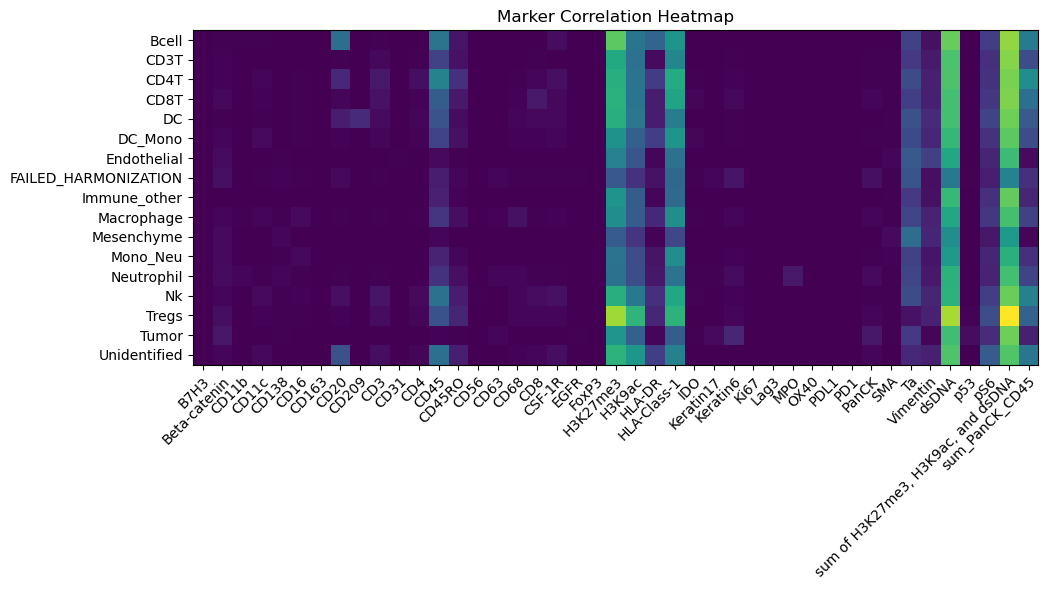

In [22]:
cell_types = means.index.values
markers = means.columns.values



fig, ax = plt.subplots(figsize = (20,6))
im = ax.imshow(means.values)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(markers)), labels=markers, fontsize = 10)
ax.set_yticks(np.arange(len(cell_types)), labels=cell_types, fontsize = 10)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax.set_title("Marker Correlation Heatmap")
fig.tight_layout()
plt.savefig('marker_heatmap.png')
plt.show()

# Train and Validate Neural Network

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import sklearn

In [24]:
training_data = df.copy()
ROWS_TO_DROP = ['FAILED_HARMONIZATION','Unidentified']
training_data = training_data.drop(labels = COLS_TO_DROP,axis=1)
training_data = training_data[training_data.cell_type.apply(lambda x: x not in ROWS_TO_DROP)]
training_data = training_data.dropna() #not sure how a NaN row got added
training_data

,cell_type,B7H3,Beta-catenin,CD11b,CD11c,CD138,CD16,CD163,CD20,CD209,...,PD1,PanCK,SMA,Ta,Vimentin,dsDNA,p53,pS6,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
71,Bcell,41.0,41.000000,41.0000,41.000000,41.000000,41.000000,41.0,49.87,41.0,...,41.0,40.0000,41.0,46.307500,41.045000,178.197500,41.0,71.392500,208.755000,68.610000
72,Macrophage,41.0,41.000000,41.1175,41.000000,41.000000,41.000000,41.0,41.00,41.0,...,41.0,40.0000,41.0,174.377500,41.000000,89.112500,41.0,62.025000,108.927500,44.757500
73,Tumor,41.0,41.000000,41.0000,41.000000,41.000000,41.000000,41.0,41.00,41.0,...,41.0,46.9075,41.0,56.247500,41.000000,69.127500,41.0,42.537500,76.992500,49.145000
75,Tumor,41.0,41.000000,41.0000,41.000000,41.000000,41.000000,41.0,41.00,41.0,...,41.0,53.4900,41.0,116.062500,41.000000,130.362500,41.0,51.497500,140.050000,58.660000
76,CD8T,41.0,41.000000,41.0000,41.000000,41.175000,41.000000,41.0,42.16,41.0,...,41.0,41.7050,41.0,76.455000,41.015000,124.672500,41.0,50.452500,139.175000,69.982500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204220,Mesenchyme,41.0,41.000000,41.0000,41.000000,41.000000,41.308594,41.0,41.00,41.0,...,41.0,41.0000,41.0,64.890625,50.230469,87.550781,41.0,41.070312,94.734375,47.101562
204221,Macrophage,41.0,41.000000,41.0000,42.300781,41.000000,41.000000,41.0,41.00,41.0,...,41.0,41.0000,41.0,60.609375,41.582031,90.894531,41.0,41.000000,92.656250,63.277344
204222,Macrophage,41.0,47.589844,41.0000,41.171875,41.433594,41.562500,41.0,41.00,41.0,...,41.0,56.5625,40.0,196.242188,41.000000,103.679688,41.0,41.000000,111.957031,61.019531
204224,Mono_Neu,41.0,41.000000,41.0000,41.000000,41.000000,43.691406,41.0,41.00,41.0,...,41.0,41.0000,41.0,53.257812,50.003906,76.613281,41.0,41.093750,86.464844,75.652344


In [25]:
reverse_map = { 'Background': 0,
  'Unidentified':1,
  'Endothelial':2,
  'Mesenchyme':3,
   'Tumor':4,
   'Tregs':5,
   'CD4T':6,
   'CD8T':7,
   'CD3T':8,
   'Nk':9,
   'Bcell':10,
   'Neutrophil':11,
   'Macrophage':12,
   'DC':13,
   'DC_Mono':14,
   'Mono_Neu':15,
   'Immune_other':16,
   'FAILED_HARMONIZATION':17,}

In [26]:
training_data.cell_type = training_data.cell_type.map(reverse_map)
training_data

,cell_type,B7H3,Beta-catenin,CD11b,CD11c,CD138,CD16,CD163,CD20,CD209,...,PD1,PanCK,SMA,Ta,Vimentin,dsDNA,p53,pS6,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
71,10,41.0,41.000000,41.0000,41.000000,41.000000,41.000000,41.0,49.87,41.0,...,41.0,40.0000,41.0,46.307500,41.045000,178.197500,41.0,71.392500,208.755000,68.610000
72,12,41.0,41.000000,41.1175,41.000000,41.000000,41.000000,41.0,41.00,41.0,...,41.0,40.0000,41.0,174.377500,41.000000,89.112500,41.0,62.025000,108.927500,44.757500
73,4,41.0,41.000000,41.0000,41.000000,41.000000,41.000000,41.0,41.00,41.0,...,41.0,46.9075,41.0,56.247500,41.000000,69.127500,41.0,42.537500,76.992500,49.145000
75,4,41.0,41.000000,41.0000,41.000000,41.000000,41.000000,41.0,41.00,41.0,...,41.0,53.4900,41.0,116.062500,41.000000,130.362500,41.0,51.497500,140.050000,58.660000
76,7,41.0,41.000000,41.0000,41.000000,41.175000,41.000000,41.0,42.16,41.0,...,41.0,41.7050,41.0,76.455000,41.015000,124.672500,41.0,50.452500,139.175000,69.982500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204220,3,41.0,41.000000,41.0000,41.000000,41.000000,41.308594,41.0,41.00,41.0,...,41.0,41.0000,41.0,64.890625,50.230469,87.550781,41.0,41.070312,94.734375,47.101562
204221,12,41.0,41.000000,41.0000,42.300781,41.000000,41.000000,41.0,41.00,41.0,...,41.0,41.0000,41.0,60.609375,41.582031,90.894531,41.0,41.000000,92.656250,63.277344
204222,12,41.0,47.589844,41.0000,41.171875,41.433594,41.562500,41.0,41.00,41.0,...,41.0,56.5625,40.0,196.242188,41.000000,103.679688,41.0,41.000000,111.957031,61.019531
204224,15,41.0,41.000000,41.0000,41.000000,41.000000,43.691406,41.0,41.00,41.0,...,41.0,41.0000,41.0,53.257812,50.003906,76.613281,41.0,41.093750,86.464844,75.652344


In [27]:
X = training_data.iloc[:,1:].values
y = training_data.iloc[:,0:1]
 
ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown = 'ignore',sparse_output= False).fit(y)
y = ohe.transform(y)

In [28]:
val_idx = int(0.7*len(X))
test_idx = int(0.8*len(X))
train_X = torch.tensor(X[0:val_idx],dtype = torch.float32)
train_y = torch.tensor(y[0:val_idx],dtype = torch.float32)
val_X = torch.tensor(X[val_idx:test_idx],dtype = torch.float32)
val_y = torch.tensor(y[val_idx:test_idx],dtype = torch.float32)
test_X = torch.tensor(X[test_idx:],dtype = torch.float32)
test_y = torch.tensor(y[test_idx:],dtype = torch.float32)

In [29]:
torch.manual_seed(0)
model = nn.Sequential(
    nn.Flatten(),  
    nn.Linear(43, 1000),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Flatten(),  
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(500, 300),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(100, 15),
)

In [30]:
def train_model(train_loader,val_loader, model,optimizer,loss_fn,num_epochs):
    
    ##### TRAIN ######
    model.train()
    N = len(train_loader.dataset)
    
    for epoch in range(num_epochs):
        total_correct = 0
        train_loss = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = loss_fn(output, target)
            train_loss+= loss.item()
            
            pred = output
            total_correct += ((torch.argmax(pred,1) == torch.argmax(target,1))).sum().item()
            

            # Backward pass
            loss.backward()

            # Weight update
            optimizer.step()
            
        train_loss = train_loss/N
        train_accuracy = total_correct /N
        
        ##### VALIDATE ######
        if epoch % 5 == 0:
            print('Train Epoch: %d Loss %.4f Accuracy %.4f' % (epoch +1,train_loss,train_accuracy))
            
            # Putting layers like Dropout into evaluation mode
            model.eval()

            test_loss = 0
            correct = 0

            # Turning off automatic differentiation
            with torch.no_grad():
                for data, target in val_loader:
                    output = model(data)

                    test_loss += loss_fn(output, target).item()  # Sum up batch loss
                    pred = output
                    correct += ((torch.argmax(pred,1) == torch.argmax(target,1))).sum().item()



            test_loss /= len(val_loader.dataset)

            print('Validation set: Accuracy: %.4f' % (100. * correct / len(val_loader.dataset)))
        
            
    return model
        

In [40]:

train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
val_dataset = torch.utils.data.TensorDataset(val_X, val_y)
test_dataset = torch.utils.data.TensorDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=400, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=400, shuffle=True) 

lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = 3e-5)
loss_fn = nn.CrossEntropyLoss()

model = train_model(train_loader,val_loader,model,optimizer,loss_fn,80)

torch.save(model, 'model.pt')

Train Epoch: 1 Loss 0.0116 Accuracy 0.6777
Validation set: Accuracy: 73.6949
Train Epoch: 6 Loss 0.0054 Accuracy 0.8292
Validation set: Accuracy: 79.9057
Train Epoch: 11 Loss 0.0052 Accuracy 0.8318
Validation set: Accuracy: 80.1026
Train Epoch: 16 Loss 0.0051 Accuracy 0.8347
Validation set: Accuracy: 80.4248
Train Epoch: 21 Loss 0.0051 Accuracy 0.8362
Validation set: Accuracy: 79.9177
Train Epoch: 26 Loss 0.0050 Accuracy 0.8386
Validation set: Accuracy: 80.2816
Train Epoch: 31 Loss 0.0049 Accuracy 0.8395
Validation set: Accuracy: 80.3353
Train Epoch: 36 Loss 0.0049 Accuracy 0.8414
Validation set: Accuracy: 80.8007
Train Epoch: 41 Loss 0.0048 Accuracy 0.8429
Validation set: Accuracy: 80.5859
Train Epoch: 46 Loss 0.0047 Accuracy 0.8441
Validation set: Accuracy: 79.6731
Train Epoch: 51 Loss 0.0047 Accuracy 0.8460
Validation set: Accuracy: 80.0251
Train Epoch: 56 Loss 0.0047 Accuracy 0.8466
Validation set: Accuracy: 80.7112
Train Epoch: 61 Loss 0.0046 Accuracy 0.8478
Validation set: Accura

# Run on Test Set

In [41]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output
        correct += ((torch.argmax(pred,1) == torch.argmax(target,1))).sum().item()



test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0025, Accuracy: 24300/33523 (72.4875)


# Load Model from Saved File and Make Confusion Matrix


In [42]:
m_ = torch.load('model.pt')


y_cm = training_data.iloc[test_idx :,0].values

X = training_data.iloc[:,1:].values
X_cm = torch.tensor(X[test_idx:],dtype = torch.float32)
dummy_y = np.zeros(len(X_cm))
dummy_y = torch.tensor(dummy_y,dtype = torch.float32)


test_dataset = torch.utils.data.TensorDataset(X_cm,dummy_y)
# Putting layers like Dropout into evaluation mode
m_.eval()

offset = 2
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False) 
y_pred = []

# Turning off automatic differentiation
with torch.no_grad():
    for data,target in test_loader:
        output = m_(data)
        
        pred = (torch.argmax(output,1))[0].item()+offset
        y_pred.append(pred)
        


In [43]:
cm = confusion_matrix(y_cm, y_pred)
cm_norm = []
for i in range(len(cm)):
    cm_norm.append(cm[i]/np.sum(cm[i]))
cm_norm = np.array(cm_norm)
cm_norm = np.around(cm_norm, decimals = 2)

In [44]:
cm_labels = [ 'Endothelial', 'Mesenchyme', 'Tumor', 'Tregs', 'CD4T', 'CD8T', 'CD3T', 'Nk', 'Bcell', 'Neutrophil', 'Macrophage', 'DC', 'DC_Mono', 'Mono_Neu', 'Immune_other']

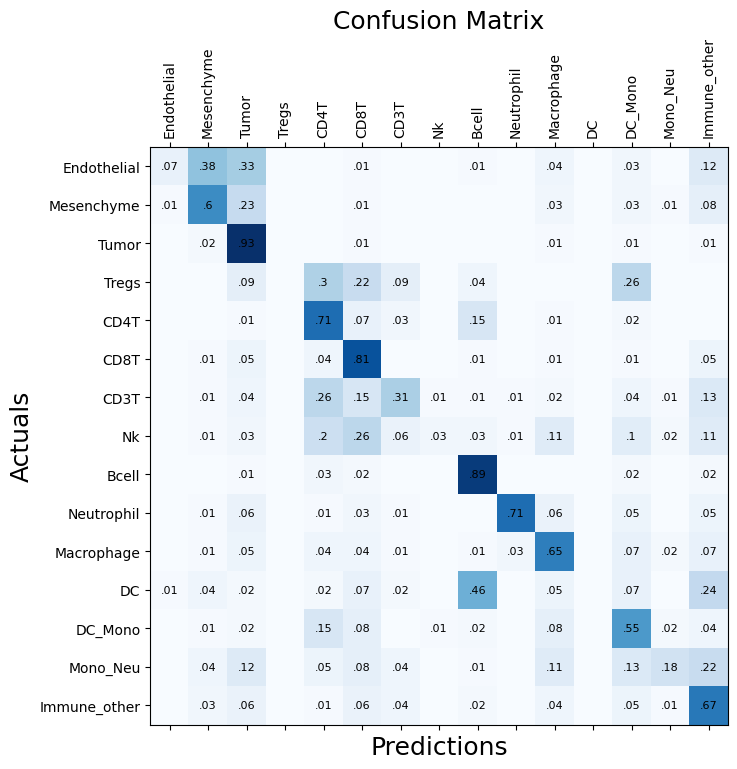

In [45]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm_norm, cmap=plt.cm.Blues,)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        if cm_norm[i, j] != 0:
          s = cm_norm[i, j]
          if s <1: #drop 0 before decimal place
            s=str(cm_norm[i, j])[1:]
          ax.text(x=j, y=i,s=s, va='center', ha='center', fontsize = 8)

ax.set_xticks(np.arange(len(cm_labels)), labels=cm_labels)
ax.set_yticks(np.arange(len(cm_labels)), labels=cm_labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation='vertical')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.savefig('confusion_matrix.png')
plt.show()

# Wrapper Function for Predicting on a New dataset

In [46]:
def make_test_loader(X_test):
    X_test = torch.tensor(X_test,dtype = torch.float32)
    dummy_y = np.zeros(len(X_test))
    dummy_y = torch.tensor(dummy_y,dtype = torch.float32)
    
    test_dataset = torch.utils.data.TensorDataset(X_test,dummy_y)
    
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False) 
    
    return test_loader

def predict(model,test_loader):
    model.eval()
    
    offset = 2
    y_pred = []

    # Turning off automatic differentiation
    with torch.no_grad():
        for data,target in test_loader:
            output = m_(data)

            pred = (torch.argmax(output,1))[0].item()+offset
            y_pred.append(pred)
            
    return y_pred

def preprocess_and_predict(X,Y,model_file,HEADER,COLS_TO_DROP):
    """inputs: X (matrix of shape (1,2048,2048,51) or (2048,2048,51) and 
               Y (matrix of shape (1,2048,2048,2) or (2048,2048,2)
       outputs: y_pred (dictionary of cell_instance:predicted class as a number)"""
    
    print("Bounding box sizes will be chosen for each image based on a sample mean of 100 whole cell dimensions in case magnification changes")
    

    X_ = X
    Y_ = Y
    
    #if X doesnt have a batch dimension, add one
    if len(X_.shape) ==3:
        X_ = [X]
        Y_ = [Y]
        
    df = []
    
    #if there are multiple batches, iterate over each one
    for X,Y in zip(X_,Y_): 
        
        X = normalize_(X)
        values = np.unique(Y[:,:,0])
        
        #make bogus C to avoid changing preprocessing functions just for this
        C  = {}
        for cell_id in values:
            C[cell_id] = cell_id
        #preprocess data
        cell_images = preprocess(X,Y,C)
        
        for cell in cell_images:
            cell_id = cell[1]
            row = [cell_id]
            for c in range(51):
                c_mean = np.mean(cell[0][:,:,c])
                row.append(c_mean)
            df.append(row)
    
    #make into df
    df = pd.DataFrame(df,columns = HEADER[1:]) #HEADER[0] is filename
    
    #make test_loader
    y_nums = df['cell_type'].values #actually is cell_id
    columns_to_drop = ['cell_type','Au','C','P','Fe','Na','Si','Ca','background']
    df = df.drop(labels = columns_to_drop,axis=1)
    X_test = df.values
    test_loader = make_test_loader(X_test)
    
    #load model
    model = torch.load('model.pt')
        
    y_pred = predict(model,test_loader)
    
    #make dictionary
    y_pred_ = {}
    for cell_id, pred in zip(y_nums,y_pred):
        y_pred_[cell_id] = pred
    
    y_pred_[0] = 0
    return y_pred_

# Verify Preprocess_and_predict actually works

In [47]:
p1 = np.load('keren/Point10.npz', allow_pickle=True)
X1 = p1['X']
Y1 = p1['y']
C1 = p1['cell_types']
C1 = C1.item()

y_pred = preprocess_and_predict(X1,Y1,'model.sav',HEADER,COLS_TO_DROP)

Bounding box sizes will be chosen for each image based on a sample mean of 100 whole cell dimensions in case magnification changes
. x avg: 19.84 x std: 7.798358801696675
. y avg: 20.75 y std: 8.709047020196872
. Choosing bounding box size = 20


In [48]:
correct = 0
n = 0
for cell_id,cell_type in C1.items():
    if cell_type in [0,1,17]:
        continue
    else:
        n +=1
        if y_pred.get(cell_id) == cell_type:
            correct += 1 
print(correct/n)

0.793010091065715
